<a href="https://colab.research.google.com/github/CastHash532/flaml-automl/blob/main/Notebooks/Flaml-vs-autokeras-kaggle-titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Authenticating with Kaggle using kaggle.json

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below to upload kaggle.json to your Colab runtime.

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


## Load data and preprocess



In [6]:
!kaggle competitions download -c titanic

test.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!ls

ds_test.csv   gender_submission.csv  structured_data_classifier  train.csv
ds_train.csv  sample_data	     test.csv


In [8]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('train.csv')

In [9]:
from sklearn.model_selection import train_test_split
ds_train , ds_test = train_test_split(dataset, test_size=0.2, random_state=42)

train_file_path = '/content/ds_train.csv'
test_file_path = '/content/ds_test.csv'
ds_train.to_csv(train_file_path)
ds_test.to_csv(test_file_path)

In [10]:
X_train = ds_train.drop('Survived', axis=1)
y_train = ds_train['Survived']
X_test = ds_test.drop('Survived', axis=1)
y_test = ds_test['Survived']

## Run FLAML
In the FLAML automl run configuration, users can specify the task type, time budget, error metric, learner list, whether to subsample, resampling strategy type, and so on. All these arguments have default values which will be used if users do not provide them. For example, the default ML learners of FLAML are `['lgbm', 'xgboost', 'catboost', 'rf', 'extra_tree', 'lrl1']`. 

In [15]:
!pip install flaml[notebook];

In [16]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [17]:
settings = {
    "time_budget": 240,  # total running time in seconds
    "metric": 'accuracy',  # can be: 'r2', 'rmse', 'mae', 'mse', 'accuracy', 'roc_auc', 'roc_auc_ovr',
                           # 'roc_auc_ovo', 'log_loss', 'mape', 'f1', 'ap', 'ndcg', 'micro_f1', 'macro_f1'
    "task": 'classification',  # task type    
    "log_file_name": 'airlines_experiment.log',  # flaml log file
    "seed": 7654321,    # random seed
}

In [18]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl: 09-19 14:41:49] {1427} INFO - Evaluation method: cv
[flaml.automl: 09-19 14:41:49] {1473} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 09-19 14:41:49] {1505} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'lrl1']
[flaml.automl: 09-19 14:41:49] {1735} INFO - iteration 0, current learner lgbm
[flaml.automl: 09-19 14:41:50] {1920} INFO -  at 0.3s,	best lgbm's error=0.2079,	best lgbm's error=0.2079
[flaml.automl: 09-19 14:41:50] {1735} INFO - iteration 1, current learner lgbm
[flaml.automl: 09-19 14:41:50] {1920} INFO -  at 0.5s,	best lgbm's error=0.2079,	best lgbm's error=0.2079
[flaml.automl: 09-19 14:41:50] {1735} INFO - iteration 2, current learner lgbm
[flaml.automl: 09-19 14:41:50] {1920} INFO -  at 0.7s,	best lgbm's error=0.2037,	best lgbm's error=0.2037
[flaml.automl: 09-19 14:41:50] {1735} INFO - iteration 3, current learner xgboost
[flaml.automl: 09-19 14:41:51] {1920} INFO -  at 1.6s,	best xgboost's error

### Best model and metric

In [19]:
''' retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: catboost
Best hyperparmeter config: {'early_stopping_rounds': 22, 'learning_rate': 0.027169076557905677}
Best accuracy on validation data: 0.8384
Training duration of best run: 2.321 s


In [20]:
automl.model.estimator

In [21]:
''' compute predictions of testing dataset ''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]

Predicted labels [0 0 0 1 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0
 1 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 1 1 0 1
 0 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1
 0 1 0 0 0 0 1 1 0 0 1 1 1 0 0 1 0 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0 1 1]
True labels 709    1
439    0
840    0
720    1
39     1
      ..
433    0
773    0
25     1
84     1
10     1
Name: Survived, Length: 179, dtype: int64


In [22]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))


accuracy = 0.8044692737430168


See Section 4 for an accuracy comparison with default LightGBM and XGBoost.

### Log history

In [23]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=240)
for config in config_history:
    print(config)

{'Current Learner': 'lgbm', 'Current Sample': 712, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0}}
{'Current Learner': 'lgbm', 'Current Sample': 712, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 12, 'learning_rate': 0.26770501231052046, 'log_max_bin': 7, 'colsample_bytree': 1.0, 'reg_alpha': 0.001348364934537134, 'reg_lambda': 1.4442580148221913}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 12, 'learning_rate': 0.26770501231052046, 'log_max_bin': 7, 'colsample_bytree': 1.0, 'reg_alp

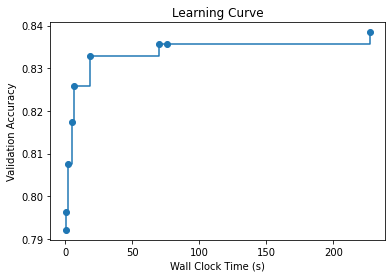

In [24]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.show()

## Autokeras

In [30]:
!pip install autokeras

In [35]:
import pandas as pd
import numpy as np
import tensorflow as tf
import autokeras as ak

# Initialize the structured data classifier.
clf = ak.StructuredDataClassifier(
    overwrite=True, max_trials=10
)  # It tries 3 different models.

In [36]:
# Feed the structured data classifier with training data.
clf.fit(
    # The path to the train.csv file.
    train_file_path,
    # The name of the label column.
    "Survived",
    epochs=30,
)

Trial 10 Complete [00h 00m 09s]
val_accuracy: 0.8653846383094788

Best val_accuracy So Far: 0.875
Total elapsed time: 00h 01m 31s
INFO:tensorflow:Oracle triggered exit
Epoch 1/30
23/23 [==============================] - 1s 5ms/step - loss: 0.6643 - accuracy: 0.5997
Epoch 2/30
23/23 [==============================] - 0s 5ms/step - loss: 0.5966 - accuracy: 0.7289
Epoch 3/30
23/23 [==============================] - 0s 5ms/step - loss: 0.5349 - accuracy: 0.7739
Epoch 4/30
23/23 [==============================] - 0s 5ms/step - loss: 0.4796 - accuracy: 0.7978
Epoch 5/30
23/23 [==============================] - 0s 5ms/step - loss: 0.4478 - accuracy: 0.8034
Epoch 6/30
23/23 [==============================] - 0s 5ms/step - loss: 0.4313 - accuracy: 0.8118
Epoch 7/30
23/23 [==============================] - 0s 5ms/step - loss: 0.4196 - accuracy: 0.8118
Epoch 8/30
23/23 [==============================] - 0s 5ms/step - loss: 0.4101 - accuracy: 0.8174
Epoch 9/30
23/23 [==============================

In [37]:
# Predict with the best model.
predicted_y = clf.predict(test_file_path)

6/6 [==============================] - 0s 4ms/step


In [38]:
# Evaluate the best model with testing data.
print(clf.evaluate(test_file_path, "Survived"))

6/6 [==============================] - 0s 4ms/step - loss: 0.5732 - accuracy: 0.7821
[0.5732184648513794, 0.7821229100227356]
